In [1]:
import os, random, sys, keras
import numpy as np
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.layers.wrappers import TimeDistributed
from keras.layers.noise import GaussianNoise
from keras.optimizers import Adam
from keras.datasets import mnist
from keras.callbacks import TensorBoard
import tensorflow as tf

import seaborn as sns
from tqdm import tqdm

import drugdiscovery as dd
import matplotlib 
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

Using TensorFlow backend.
2017-12-05 22:53.08 [info     ] env-capture                    [drugdiscovery] env='prod' version='0.5+960.g44ec64a9.dirty'


In [2]:
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print(np.min(X_train), np.max(X_train))

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

0.0 1.0
X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [17]:
shp = X_train.shape[1:]
dropout_rate = 0.2
opt = Adam(lr=1e-4)
dopt = Adam(lr=1e-3)

In [18]:
# Build Generative model ...
depth = 64*4
dim = 7
generator = Sequential()

generator.add(Dense(dim*dim*depth, kernel_initializer='glorot_normal', input_dim=100))
generator.add(BatchNormalization(momentum=.9))
generator.add(Activation('relu'))
generator.add(Reshape( [dim,dim,depth] ))
generator.add(Dropout(dropout_rate))

generator.add(UpSampling2D())
generator.add(Conv2DTranspose(depth//2, 5, padding='same'))
generator.add(BatchNormalization(momentum=.9))
generator.add(Activation('relu'))

generator.add(UpSampling2D())
generator.add(Conv2DTranspose(depth//4, 5, padding='same'))
generator.add(BatchNormalization(momentum=.9))
generator.add(Activation('relu'))

generator.add(Conv2DTranspose(depth//8, 5, padding='same'))
generator.add(BatchNormalization(momentum=.9))
generator.add(Activation('relu'))

generator.add(Conv2DTranspose(1, 5, padding='same'))
generator.add(Activation('sigmoid'))

generator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_9 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_12 (Activation)   (None, 12544)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 14, 14, 128)       819328    
__________

In [19]:
# Build Discriminative model ...
depth = 64
input_shape = (img_rows, img_cols, 1)
discriminator = Sequential()

discriminator.add(Conv2D(depth*1, 5, padding='same', activation='relu', strides=2,
                        input_shape=input_shape))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(dropout_rate))

discriminator.add(Conv2D(depth*2, 5, padding='same', activation='relu', strides=2))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(dropout_rate))

discriminator.add(Conv2D(depth*4, 5, padding='same', activation='relu', strides=2))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(dropout_rate))

discriminator.add(Conv2D(depth*8, 5, padding='same', activation='relu', strides=2))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(dropout_rate))

discriminator.add(Flatten())
discriminator.add(Dense(1))
discriminator.add(Activation('sigmoid'))

discriminator.compile(loss='binary_crossentropy', optimizer=dopt, metrics=['accuracy'])
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 256)         819456    
__________

In [20]:
# Freeze weights in the discriminator for stacked training
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val
make_trainable(discriminator, False)

# Build stacked GAN model
GAN = Sequential()
GAN.add(generator)
GAN.add(discriminator)
GAN.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
GAN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 28, 28, 1)         2394241   
_________________________________________________________________
sequential_6 (Sequential)    (None, 1)                 4305409   
Total params: 6,699,650.0
Trainable params: 2,368,705.0
Non-trainable params: 4,330,945.0
_________________________________________________________________


In [21]:
def plot_loss(losses):
#        display.clear_output(wait=True)
#        display.display(plt.gcf())
    d_loss, d_acc = zip(*losses['d'])
    g_loss, g_acc = zip(*losses['g'])
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,3))

    ax1.set_title('Losses')
    ax1.plot(d_loss, label='discriminator')
    ax1.plot(g_loss, label='generator')
    ax1.legend()
    
    ax2.set_title('Accuracy')
    ax2.plot(d_acc, label='discriminator')
    ax2.plot(g_acc, label='generator')
    ax2.legend()
    
    plt.show()

def plot_gen(n_ex=6, dim=(1,6), figsize=(6,1), fixed_noise=None):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    if fixed_noise is not None:
        noise[:fixed_noise.shape[0],:] = fixed_noise[:,:]
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,:,:,0]
        plt.imshow(img,cmap='gray')
        plt.axis('off')
    plt.show()
    
def plot_real(n_ex=16,dim=(4,4), figsize=(6,6) ):
    
    idx = np.random.randint(0,X_train.shape[0],n_ex)
    generated_images = X_train[idx,:,:,0]

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,:,:]
        plt.imshow(img,cmap='gray')
        plt.axis('off')
    plt.show()

### Pretrain?

In [22]:
ntrain = 1024
trainidx = random.sample(range(0,X_train.shape[0]), ntrain)
XT = X_train[trainidx,:,:,:]

# Pre-train the discriminator network ...
noise_gen = np.random.uniform(0,1,size=[XT.shape[0],100])
generated_images = generator.predict(noise_gen)
X = np.concatenate((XT, generated_images))
n = XT.shape[0]
y = np.zeros([2*n,1])
y[n:] = 1

make_trainable(discriminator,True)
discriminator.fit(X,y, epochs=1, batch_size=128)
y_hat = discriminator.predict(X)

# Measure accuracy of pre-trained discriminator network
y_hat_idx = np.argmax(y_hat,axis=1)
y_idx = np.argmax(y,axis=1)
diff = y_idx-y_hat_idx
n_tot = y.shape[0]
n_rig = (diff==0).sum()
acc = n_rig*100.0/n_tot
print("Accuracy: %0.02f pct (%d of %d) right" % (acc, n_rig, n_tot))

Epoch 1/1
2048/2048 [==============================] - ETA: 29s - loss: 0.6919 - acc: 0.49 - ETA: 23s - loss: 0.5699 - acc: 0.74 - ETA: 20s - loss: 1.1853 - acc: 0.66 - ETA: 18s - loss: 1.0129 - acc: 0.66 - ETA: 16s - loss: 0.9450 - acc: 0.67 - ETA: 14s - loss: 0.8308 - acc: 0.71 - ETA: 13s - loss: 0.7122 - acc: 0.75 - ETA: 11s - loss: 0.6414 - acc: 0.78 - ETA: 10s - loss: 0.5715 - acc: 0.80 - ETA: 8s - loss: 0.5158 - acc: 0.8227 - ETA: 7s - loss: 0.4725 - acc: 0.838 - ETA: 5s - loss: 0.4422 - acc: 0.849 - ETA: 4s - loss: 0.4190 - acc: 0.860 - ETA: 2s - loss: 0.3891 - acc: 0.870 - ETA: 1s - loss: 0.3649 - acc: 0.877 - 22s - loss: 0.3421 - acc: 0.8853    
Accuracy: 100.00 pct (2048 of 2048) right


In [23]:
# setup tensorboard
def write_log(callback, names, logs, batch_no):
    for name, value in zip(names, logs):
        summary = tf.Summary()
        summary_value = summary.value.add()
        summary_value.simple_value = value
        summary_value.tag = name
        callback.writer.add_summary(summary, batch_no)
        callback.writer.flush()
    
log_path_g = './logs/generator'
callback_g = TensorBoard(log_path_g)
callback_g.set_model(GAN)

log_path_d = './logs/discriminator'
callback_d = TensorBoard(log_path_d)
callback_d.set_model(discriminator)

callback_names = ['loss', 'acc']

In [10]:
# get some fixed noise inputs for watching progression
fixed_noise = np.random.uniform(0,1,size=[3,100])

In [24]:
# set up loss storage vector
losses = {"d":[], "g":[]}

# Set up our main training loop
def train_for_n(nb_epoch=10000, plt_frq=200, BATCH_SIZE=32):
    opt.lr.assign(5e-4)
    dopt.lr.assign(1e-3)
    
    for e in tqdm(range(nb_epoch)):
        # lower the learning rates for later batches
        if e == 6000:
            opt.lr.assign(5e-5)
            dopt.lr.assign(1e-4)
        if e == 8000:
            opt.lr.assign(5e-6)
            dopt.lr.assign(1e-5)
        
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=BATCH_SIZE),:,:,:]    
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        generated_images = generator.predict(noise_gen)
        
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*BATCH_SIZE,1])
        y[BATCH_SIZE:] = 1
        if e%10==0:
            y = np.ones([2*BATCH_SIZE,1])
            y[BATCH_SIZE:] = 0
        
        make_trainable(discriminator,True)
        d_log  = discriminator.train_on_batch(X, y)
        losses["d"].append(d_log)
        write_log(callback_d, callback_names, d_log, e)
    
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        y2 = np.zeros([BATCH_SIZE,1])
        
        make_trainable(discriminator,False)
        g_log = GAN.train_on_batch(noise_tr, y2)
        losses["g"].append(g_log)
        write_log(callback_g, callback_names, g_log, e)
        
        # plot samples
        if e%plt_frq==0 or (e < 200 and e%50==0):
            plot_gen(fixed_noise=fixed_noise)


  0%|          | 0/10000 [00:00<?, ?it/s]


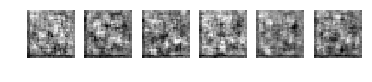

  0%|          | 5/10000 [00:22<13:00:01,  4.68s/it]

In [ ]:
# Train!!
train_for_n(nb_epoch=10000, plt_frq=200, BATCH_SIZE=32)

In [ ]:
# Plot the final loss curves
plot_loss(losses)

# Plot some generated images from our GAN
plot_gen(25,(5,5),(6,6))

# Plot real MNIST images for comparison
plot_real(25,(5,5),(6,6))